# Import libraries

In [ ]:
!pip install wordcloud
!pip install dython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 12.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd

# For text processing, cleaning
import nltk
from nltk.tag import pos_tag, map_tag
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from collections import Counter

# for visualising
import seaborn as sb
sb.set(font_scale=2) # set the default Seaborn style for graphics
import matplotlib.pyplot as plt # we only need pyplot
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

# Correlation analysis
from dython.nominal import associations


# Import dataset

In [ ]:
true = pd.read_csv('/work/20240407-150440/News _dataset/True.csv')
false = pd.read_csv('/work/20240407-150440/News _dataset/Fake.csv')

# Check for imbalance

In [ ]:
true.shape()
false.shape()

# Combine True & Fake news into a single Dataframe for easy access

In [ ]:
# Add a 'truth' column to each dataframe with the appropriate values
true['label'] = 1
false['label'] = 0

# for presentation
true['label_meaning'] = True
false['label_meaning'] = False

# Concatenate the two dataframes into a single dataframe
combined_news = pd.concat([true, false], ignore_index=True)

# shuffle the rows
news = combined_news.sample(frac=1).reset_index(drop=True)
news.head()

,title,text,subject,date,label,label_meaning
0,COMMIE OBAMA BASHES AMERICA: “I personally wou...,Wow! We REALLY do have a serious problem with ...,politics,"Mar 21, 2016",0,False
1,Fox News Frantically Tries To Cover Up Trump’...,It s not clear whether Trump called in a favor...,News,"March 26, 2017",0,False
2,"Caitlyn Jenner, teen singer appeal to Trump on...",(Reuters) - A teenaged singer with a transgend...,politicsNews,"February 23, 2017",1,True
3,LOL! “BLACK STUDENTS UNITED” Demands “Racist” ...,EAG Black Students United which represen...,left-news,"Oct 6, 2017",0,False
4,Myanmar’s Suu Kyi sets out aid plan to end Roh...,GENEVA (Reuters) - Aung San Suu Kyi has set ou...,worldnews,"October 13, 2017",1,True


About the Dataset:
title: the title of news article
subject: news article type
text: the text of the article; could be incomplete

date: date of which news article published

label: a label that marks whether the news article is real or fake:
1: True news
0: Fake News

In [ ]:
# Information about the Variables
combined_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          44898 non-null  object
 1   text           44898 non-null  object
 2   subject        44898 non-null  object
 3   date           44898 non-null  object
 4   label          44898 non-null  int64 
 5   label_meaning  44898 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.8+ MB


In [ ]:
# Dimensions of Dataframe
combined_news.shape

(44898, 6)

In [ ]:
combined_news.dtypes

title            object
text             object
subject          object
date             object
label             int64
label_meaning      bool
dtype: object

# Data Cleaning

## Data Cleaning (Check null rows)

In [ ]:
# Check if any of the columns contains NULL value
news.isnull().sum(axis=0)

title            0
text             0
subject          0
date             0
label            0
label_meaning    0
dtype: int64

None of the columns had any NULL values, so there is no need to replace NULL with median text or title wordcount, or drop any rows with NULL values.

## Data Cleaning (drop the Date column)

In [ ]:
# i think date not needed?

news.drop(['date'], axis=1, inplace=True)

news.head()

,title,text,subject,label,label_meaning
0,COMMIE OBAMA BASHES AMERICA: “I personally wou...,Wow! We REALLY do have a serious problem with ...,politics,0,False
1,Fox News Frantically Tries To Cover Up Trump’...,It s not clear whether Trump called in a favor...,News,0,False
2,"Caitlyn Jenner, teen singer appeal to Trump on...",(Reuters) - A teenaged singer with a transgend...,politicsNews,1,True
3,LOL! “BLACK STUDENTS UNITED” Demands “Racist” ...,EAG Black Students United which represen...,left-news,0,False
4,Myanmar’s Suu Kyi sets out aid plan to end Roh...,GENEVA (Reuters) - Aung San Suu Kyi has set ou...,worldnews,1,True


## Data Cleaning (Convert all text to lowercase)

In [ ]:
news['title'] = news['title'].str.lower()
news['text'] = news['text'].str.lower()
news['subject'] = news['subject'].str.lower()

news.head()

,title,text,subject,label,label_meaning
0,commie obama bashes america: “i personally wou...,wow! we really do have a serious problem with ...,politics,0,False
1,fox news frantically tries to cover up trump’...,it s not clear whether trump called in a favor...,news,0,False
2,"caitlyn jenner, teen singer appeal to trump on...",(reuters) - a teenaged singer with a transgend...,politicsnews,1,True
3,lol! “black students united” demands “racist” ...,eag black students united which represen...,left-news,0,False
4,myanmar’s suu kyi sets out aid plan to end roh...,geneva (reuters) - aung san suu kyi has set ou...,worldnews,1,True


## Data Cleaning (Remove punctuation)

In [ ]:
news['title'] = news['title'].str.replace(r'[^\w\s]', '', regex=True)
news['text'] = news['text'].str.replace(r'[^\w\s]', '', regex=True)
news['subject'] = news['subject'].str.replace(r'[^\w\s]', '', regex=True)

news.head()

,title,text,subject,label,label_meaning
0,commie obama bashes america i personally would...,wow we really do have a serious problem with t...,politics,0,False
1,fox news frantically tries to cover up trumps...,it s not clear whether trump called in a favor...,news,0,False
2,caitlyn jenner teen singer appeal to trump on ...,reuters a teenaged singer with a transgender ...,politicsnews,1,True
3,lol black students united demands racist corne...,eag black students united which represen...,leftnews,0,False
4,myanmars suu kyi sets out aid plan to end rohi...,geneva reuters aung san suu kyi has set out p...,worldnews,1,True


## Data Cleaning (Remove stopwords)

> Stop words are a set of commonly used words in a language. Examples include “a,” “the,” “is,” “are,” etc. They will be filtered out in Natural Language Processing to focus more on the meaningful and informative words.

In [ ]:
# remove stopwords (words with no meaning)
nltk.download('stopwords')

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

news['title'] = news['title'].apply(lambda text: ' '.join([word for word in text.split() if word not in stopwords_dict]))
news['text'] = news['text'].apply(lambda text: ' '.join([word for word in text.split() if word not in stopwords_dict]))

news.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,title,text,subject,label,label_meaning
0,commie obama bashes america personally would d...,wow really serious problem antiamerican jackho...,politics,0,False
1,fox news frantically tries cover trumps 13th g...,clear whether trump called favor fox news deci...,news,0,False
2,caitlyn jenner teen singer appeal trump transg...,reuters teenaged singer transgender sister bes...,politicsnews,1,True
3,lol black students united demands racist corne...,eag black students united represents people af...,leftnews,0,False
4,myanmars suu kyi sets aid plan end rohingya cr...,geneva reuters aung san suu kyi set plans new ...,worldnews,1,True


## Word stemming: Reducing a word to its root word

In [ ]:
# word stemming
nltk.download('punkt')

# Initialize the PorterStemmer
ps = PorterStemmer()

# Apply stemming to 'title' and 'text' column/

news['title'] = news['title'].apply(lambda text: ' '.join([ps.stem(word) for word in text.split()]))
news['text'] = news['text'].apply(lambda text: ' '.join([ps.stem(word) for word in text.split()]))

news.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,title,text,subject,label,label_meaning
0,commi obama bash america person would disagre ...,wow realli seriou problem antiamerican jackhol...,politics,0,False
1,fox news frantic tri cover trump 13th golf tri...,clear whether trump call favor fox news decid ...,news,0,False
2,caitlyn jenner teen singer appeal trump transg...,reuter teenag singer transgend sister best kno...,politicsnews,1,True
3,lol black student unit demand racist cornel un...,eag black student unit repres peopl african di...,leftnews,0,False
4,myanmar suu kyi set aid plan end rohingya crisi,geneva reuter aung san suu kyi set plan new hu...,worldnews,1,True


# Data Processing (adding extra relevant columns)

In [ ]:
# Add a column for the number of char for title and text
news['title_charcount'] = news['title'].str.len()
news['text_charcount'] = news['text'].str.len()

# Add a column for the number of word for title and text
news['title_wordcount'] = news['title'].str.split().str.len()
news['text_wordcount'] = news['text'].str.split().str.len()

news.head()

,title,text,subject,label,label_meaning,title_charcount,text_charcount,title_wordcount,text_wordcount
0,commi obama bash america person would disagre ...,wow realli seriou problem antiamerican jackhol...,politics,0,False,78,53,12,7
1,fox news frantic tri cover trump 13th golf tri...,clear whether trump call favor fox news decid ...,news,0,False,66,2234,12,326
2,caitlyn jenner teen singer appeal trump transg...,reuter teenag singer transgend sister best kno...,politicsnews,1,True,55,1549,8,236
3,lol black student unit demand racist cornel un...,eag black student unit repres peopl african di...,leftnews,0,False,81,2636,13,377
4,myanmar suu kyi set aid plan end rohingya crisi,geneva reuter aung san suu kyi set plan new hu...,worldnews,1,True,47,1034,9,165


## Generate Sentiment Polarity

> Polarity refers to the overall sentiment conveyed by a particular text, phrase or word. This polarity is expressed as a numerical rating known as a “sentiment score”.

In [ ]:
# adding sentiment
# Download resources needed
nltk.download('vader_lexicon')

# Init SIA object
sia = SentimentIntensityAnalyzer()

# Function to return the polarity & the corresponding confidence score
def get_polarity_score(sentence):

    polarity_score = sia.polarity_scores(sentence)

    # Get positive and negative scores
    pos_score = polarity_score['pos']
    neg_score = polarity_score['neg']
    neu_score = polarity_score['neu']

    # Determine overall sentiment polarity
    if pos_score > neg_score:
        polarity = 'positive'
        score = pos_score
    elif neg_score > pos_score:
        polarity = 'negative'
        score = neg_score
    else:
        polarity = 'neutral'
        score = neu_score  # Set score to 0.0 for neutral polarity

    return polarity, score

# Add 2 columns polarity & score for each Title and Text
news['title_polarity'], news['title_polarity_score'] = zip(*news['title'].apply(get_polarity_score))
news['text_polarity'], news['text_polarity_score'] = zip(*news['text'].apply(get_polarity_score))

news.head(100)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,title,text,subject,label,label_meaning,title_charcount,text_charcount,title_wordcount,text_wordcount,title_polarity,title_polarity_score,text_polarity,text_polarity_score
0,commi obama bash america person would disagre ...,wow realli seriou problem antiamerican jackhol...,politics,0,False,78,53,12,7,negative,0.160,positive,0.330
1,fox news frantic tri cover trump 13th golf tri...,clear whether trump call favor fox news decid ...,news,0,False,66,2234,12,326,negative,0.209,positive,0.126
2,caitlyn jenner teen singer appeal trump transg...,reuter teenag singer transgend sister best kno...,politicsnews,1,True,55,1549,8,236,neutral,1.000,positive,0.121
3,lol black student unit demand racist cornel un...,eag black student unit repres peopl african di...,leftnews,0,False,81,2636,13,377,negative,0.476,negative,0.120
4,myanmar suu kyi set aid plan end rohingya crisi,geneva reuter aung san suu kyi set plan new hu...,worldnews,1,True,47,1034,9,165,neutral,1.000,positive,0.124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,austrian justic system give teen homemad nazi ...,get far stori need point 18 year old teen sent...,leftnews,0,False,97,1915,16,300,negative,0.239,negative,0.196
96,us senat issu legisl sanction russia elect int...,washington reuter republican us senat john mcc...,politicsnews,1,True,51,189,8,27,neutral,1.000,neutral,1.000
97,trump econom advis fed good job respect independ,washington reuter white hous econom advis gari...,politicsnews,1,True,48,460,8,75,positive,0.500,positive,0.264
98,gun greek pasok shoot use past guerrilla attac...,athen reuter shot fire riot polic guard headqu...,worldnews,1,True,53,1117,9,173,negative,0.568,negative,0.188


## Parts of speech tagging (POS)

> POS tagging is process of labeling words in a text with their corresponding parts of speech (e.g., noun, verb, adjective), to better understand the grammatical structure of news articles' titles and texts.

In [ ]:
# Download required resources for POS
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

# Function to return new columns for POS count for any sentence
def pos_tagging(sentence):
    # Create temp dict
    pos_dict = {}
    # Tokenize sentence
    sentence_token = sentence.split()
    # Get pos tagging in list
    pos_list = nltk.pos_tag(sentence_token)
    # Simplify
    pos_list = [map_tag('en-ptb', 'universal', tag) for _, tag in pos_list]
    pos_dict = Counter(pos_list)
    return [pos_dict['ADJ'] if 'ADJ' in pos_dict else 0,
            pos_dict['ADV'] if 'ADV' in pos_dict else 0,
            pos_dict['NOUN'] if 'NOUN' in pos_dict else 0,
            pos_dict['NUM'] if 'NUM' in pos_dict else 0,
            pos_dict['PRON'] if 'PRON' in pos_dict else 0,
            pos_dict['VERB'] if 'VERB' in pos_dict else 0]

# Add 1 column for each pos in Title
news['title_pos_adj'], news['title_pos_adv'], news['title_pos_noun'], news['title_pos_num'], news['title_pos_pron'], news['title_pos_verb'] = zip(*news['title'].apply(pos_tagging))

# Add 1 column for each pos in Text
news['text_pos_adj'], news['text_pos_adv'], news['text_pos_noun'], news['text_pos_num'], news['text_pos_pron'], news['text_pos_verb'] = zip(*news['text'].apply(pos_tagging))

news.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


# Final cleanup

In [ ]:
# Check if any of the columns are empty string "" after cleaning
for col in news.columns:
    # Print sum of empty strings in a col
    print(f"{col}:\t\t\t{len(news[news[col] == ''])}")
    # Replace empty string with NA to clean
    news[col].replace('', np.nan, inplace=True)

title:			0
text:			632
subject:			0
label:			0
label_meaning:			0
title_charcount:			0
text_charcount:			0
title_wordcount:			0
text_wordcount:			0
title_polarity:			0
title_polarity_score:			0
text_polarity:			0
text_polarity_score:			0
title_pos_adj:			0
title_pos_adv:			0
title_pos_noun:			0
title_pos_num:			0
title_pos_pron:			0
title_pos_verb:			0
text_pos_adj:			0
text_pos_adv:			0
text_pos_noun:			0
text_pos_num:			0
text_pos_pron:			0
text_pos_verb:			0


Since no columns are empty strings, no empty string will have to be replaced by NA values.

# Save cleaned data

In [ ]:
# Save news dataframe into a csv
news.to_csv("cleaned_news_data.csv", sep=',', encoding='utf-8')

NameError: name 'news_data' is not defined

# Data Visualisation

## Visualise fake news to real news ratio

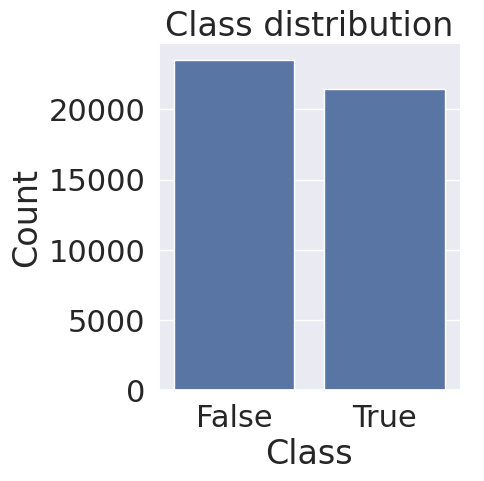

In [ ]:
# Class analysis
sb.catplot(x="label_meaning", data=news, kind = "count").set(
    title="Class distribution",
    xlabel='Class',
    ylabel='Count')

## Visualise distribution of wordcount

### Title wordcount

[Text(0.5, 1.0, 'Title wordcount violinplot'), Text(0.5, 0, 'Wordcount')]

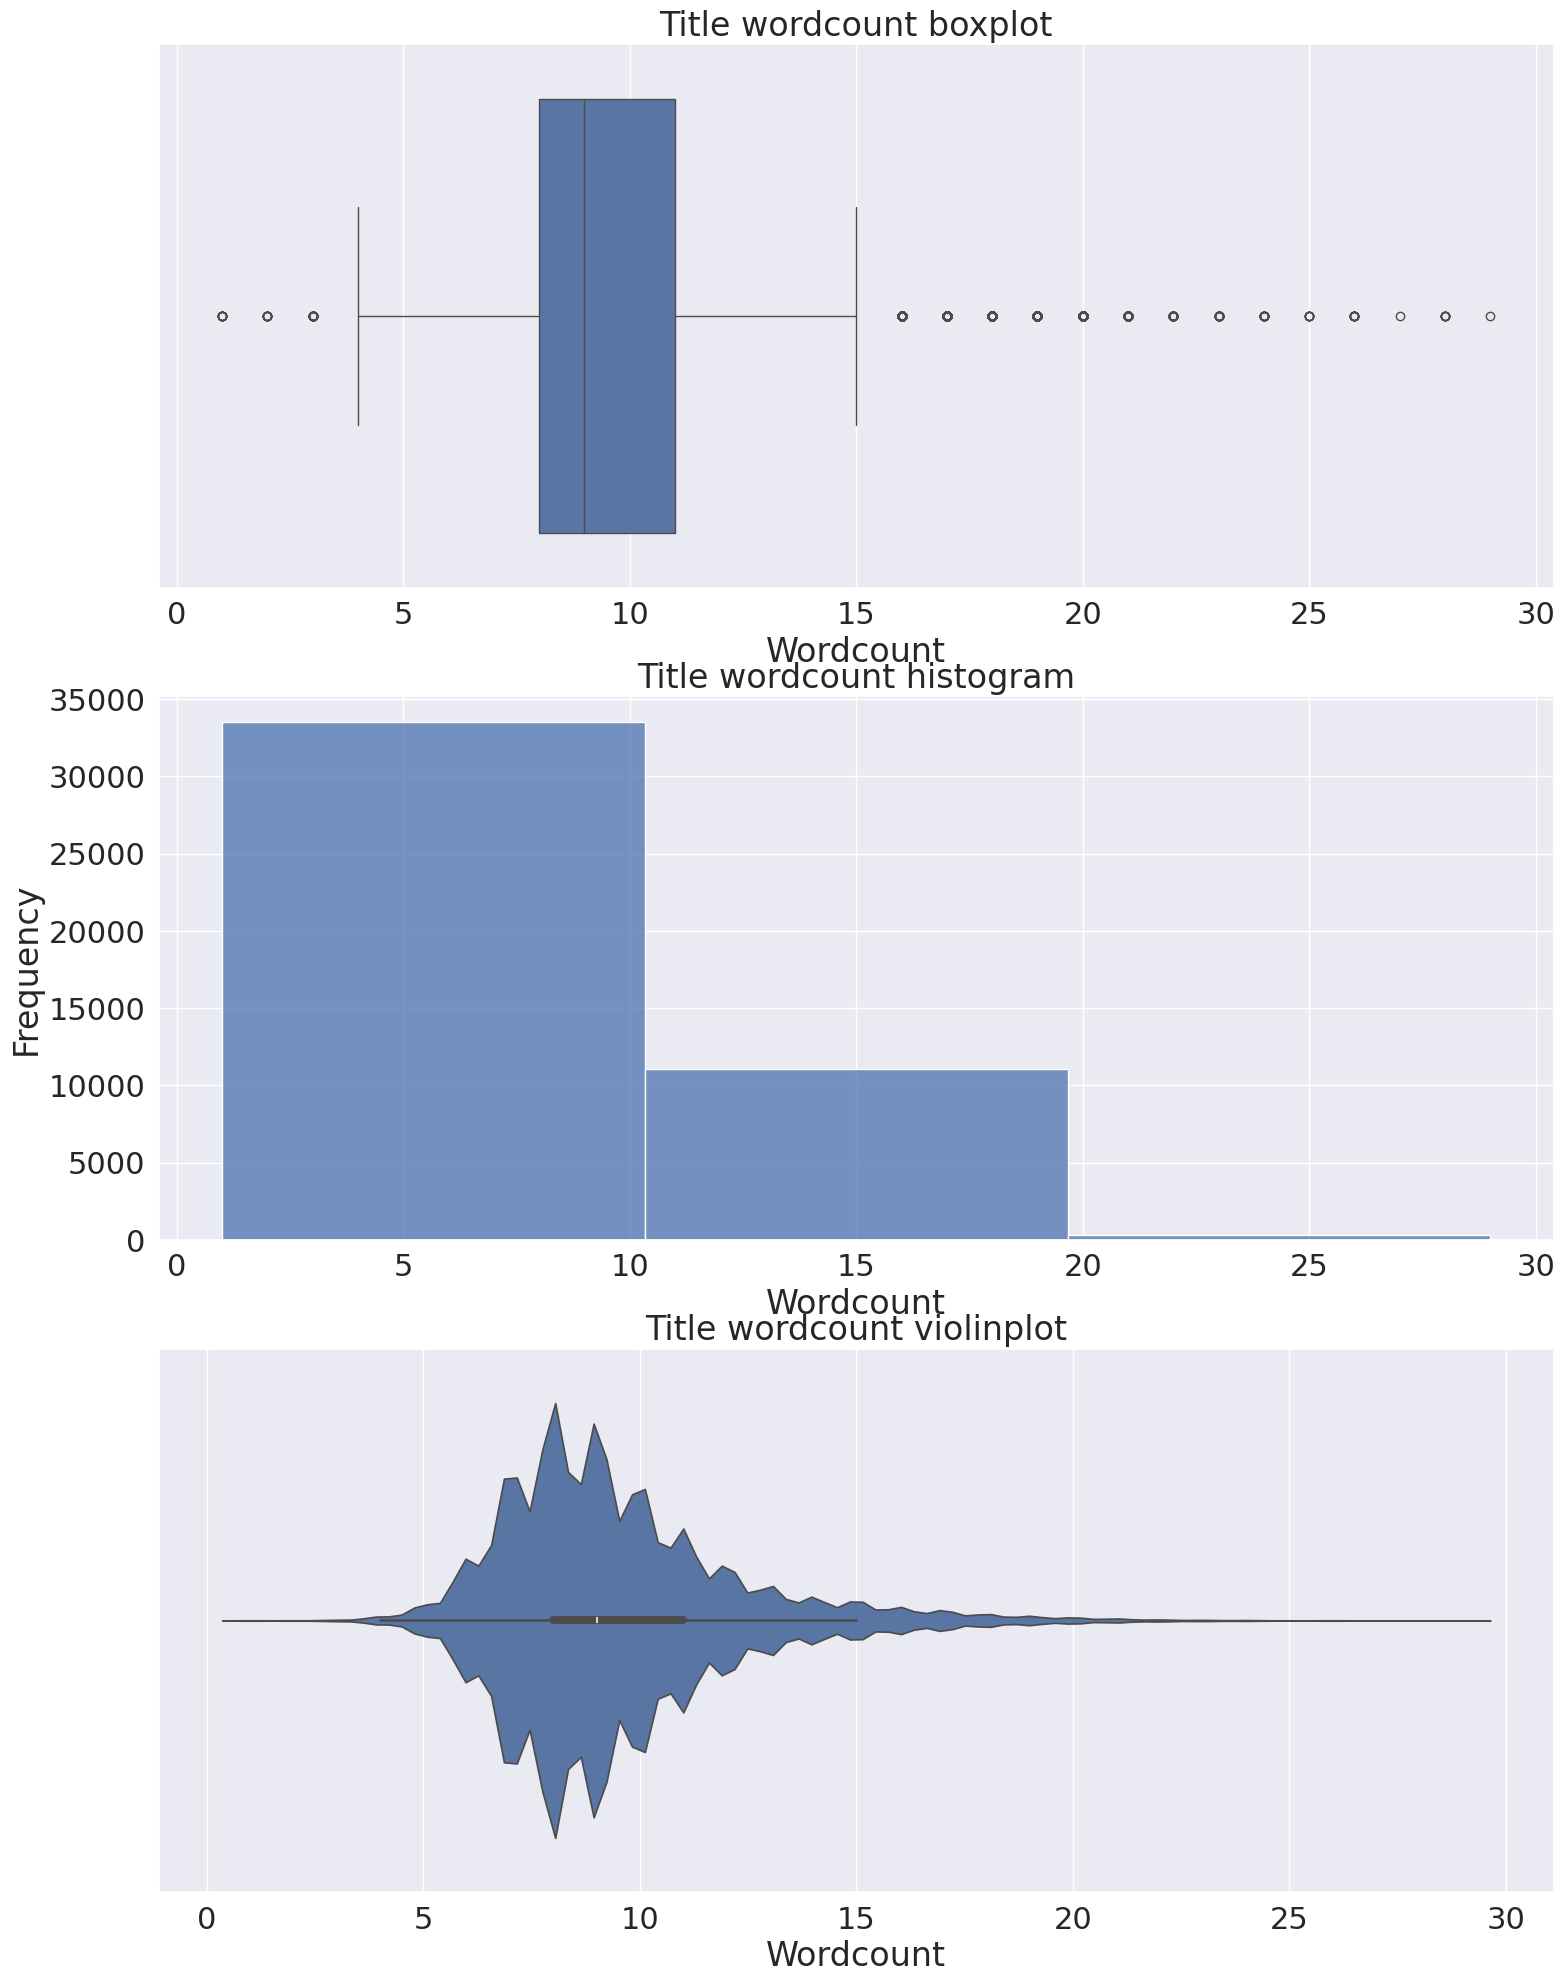

In [ ]:
# Word count analysis (Title)
f, axes = plt.subplots(3, 1, figsize=(18, 24))

# Plot distribution graphs (Boxplot & histogram & violinplot)
sb.boxplot(data=news["title_wordcount"], orient = "h", ax=axes[0]).set(
    title="Title wordcount boxplot",
    xlabel='Wordcount')
sb.histplot(data=news["title_wordcount"], binwidth=10, ax=axes[1]).set(
    title="Title wordcount histogram",
    xlabel='Wordcount',
    ylabel='Frequency')
sb.violinplot(data=news["title_wordcount"], orient = "h", ax = axes[2]).set(
    title="Title wordcount violinplot",
    xlabel='Wordcount')

In [ ]:
# view stats
news['title_wordcount'].describe()


count    44898.000000
mean         9.425698
std          2.756840
min          1.000000
25%          8.000000
50%          9.000000
75%         11.000000
max         29.000000
Name: title_wordcount, dtype: float64

### Title wordcount

[Text(0.5, 1.0, 'Title charcount violinplot'), Text(0.5, 0, 'Wordcount')]

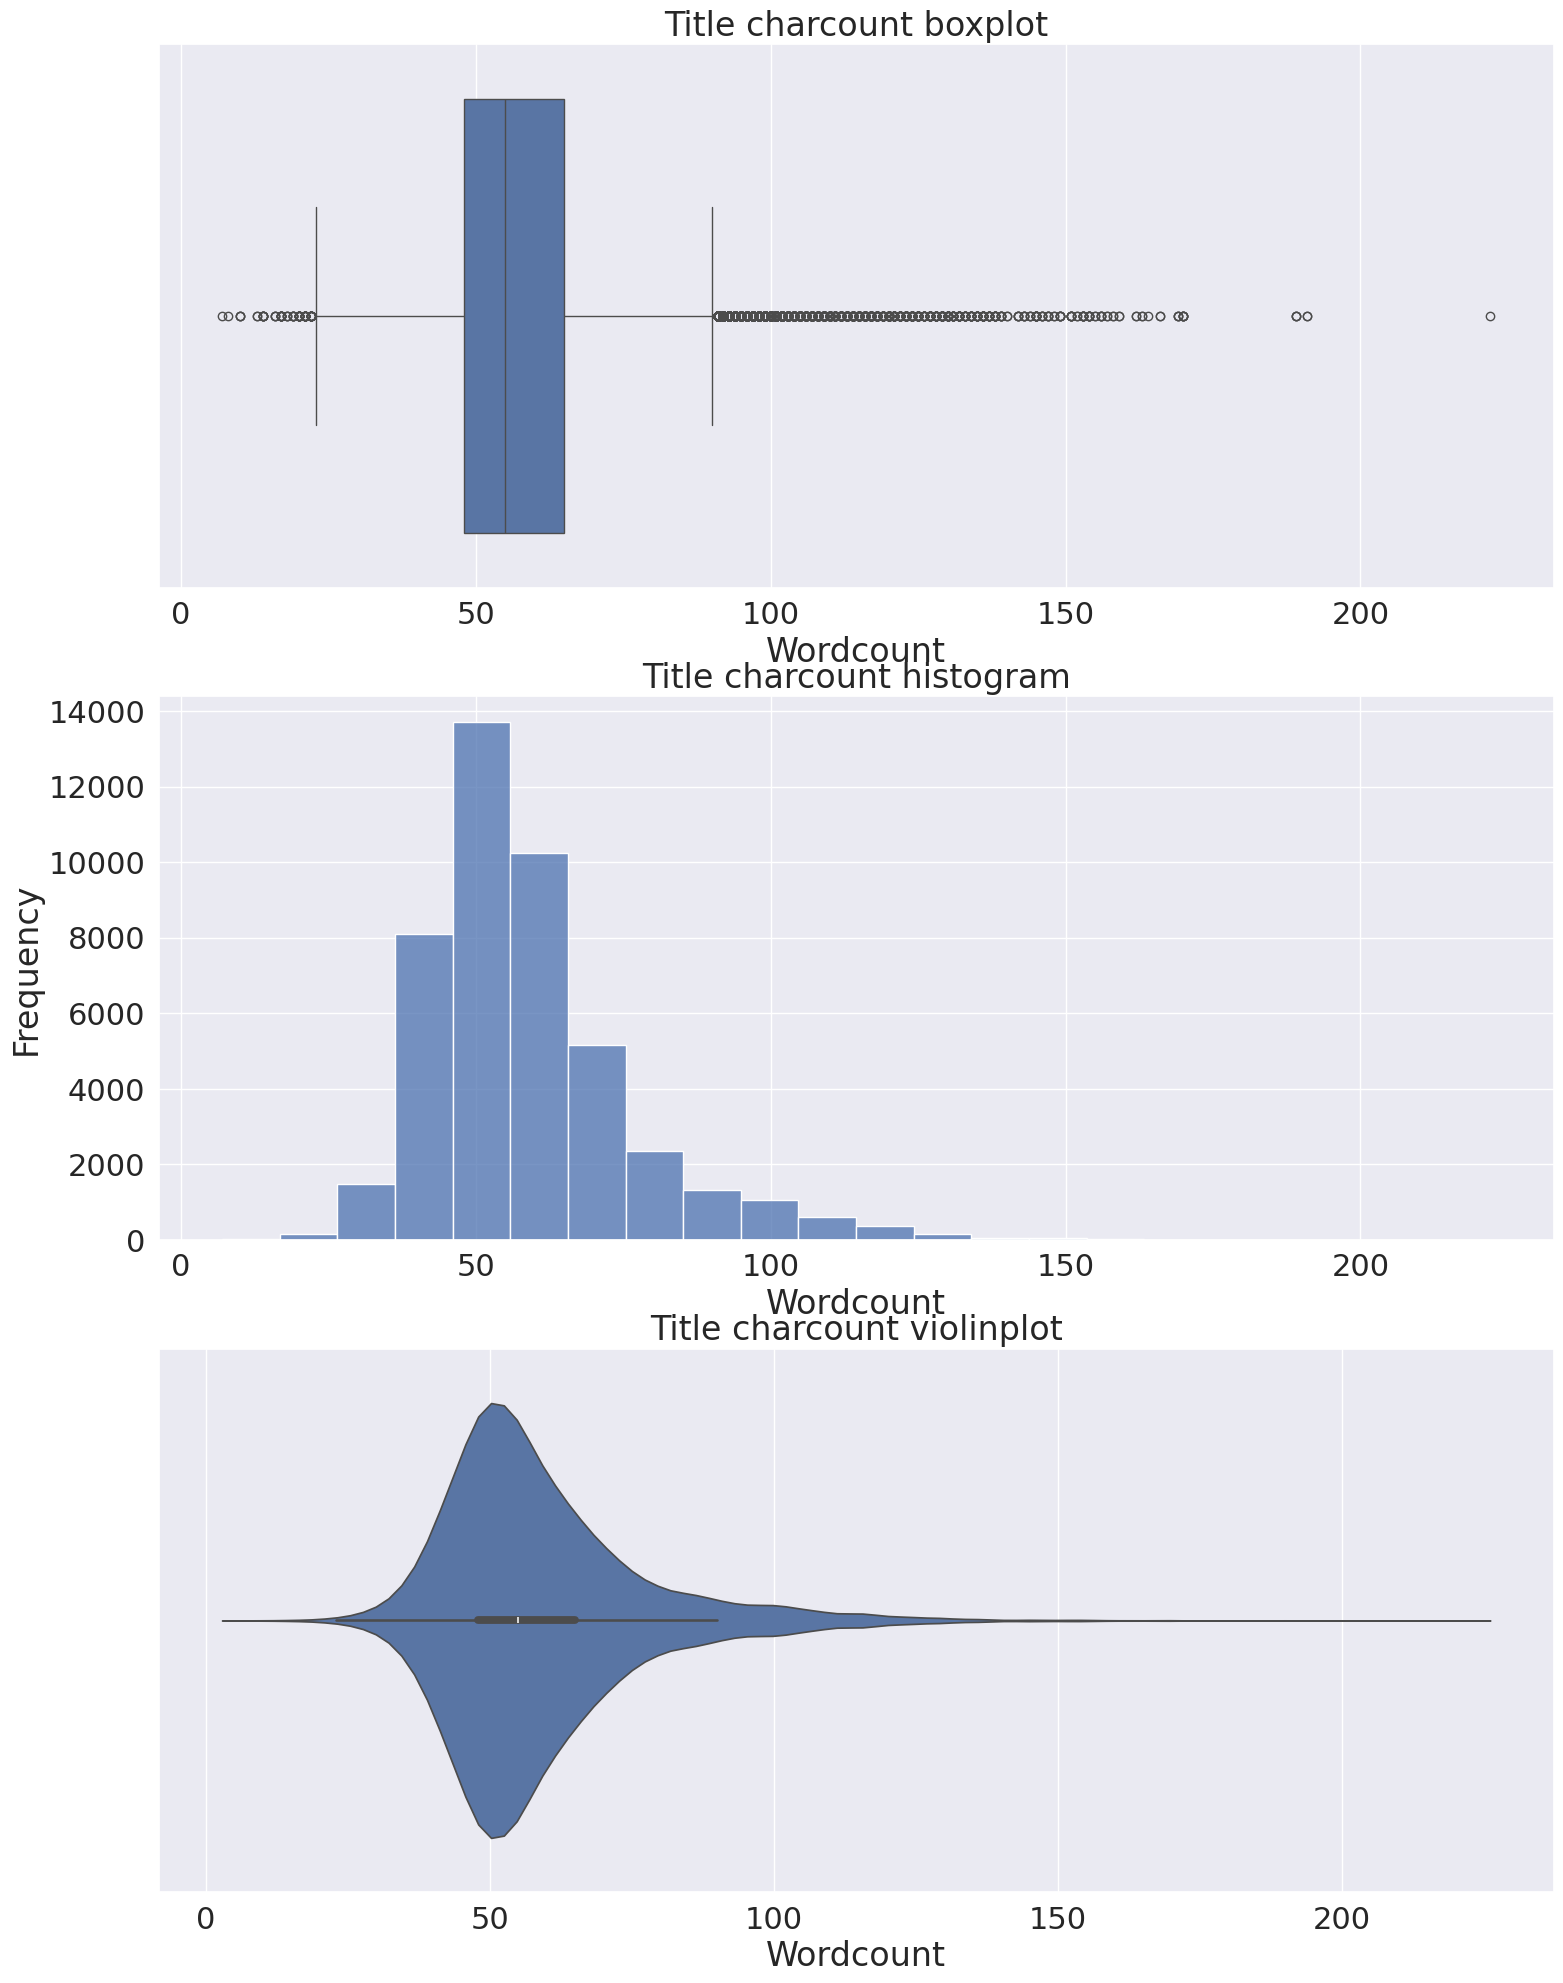

In [ ]:
# Word count analysis (Title)
f, axes = plt.subplots(3, 1, figsize=(18, 24))

# Plot distribution graphs (Boxplot & histogram & violinplot)
sb.boxplot(data=news["title_charcount"], orient = "h", ax=axes[0]).set(
    title="Title charcount boxplot",
    xlabel='Wordcount')
sb.histplot(data=news["title_charcount"], binwidth=10, ax=axes[1]).set(
    title="Title charcount histogram",
    xlabel='Wordcount',
    ylabel='Frequency')
sb.violinplot(data=news["title_charcount"], orient = "h", ax = axes[2]).set(
    title="Title charcount violinplot",
    xlabel='Wordcount')

In [ ]:
# view stats
news['title_charcount'].describe()

count    44898.000000
mean        58.682035
std         17.661527
min          7.000000
25%         48.000000
50%         55.000000
75%         65.000000
max        222.000000
Name: title_charcount, dtype: float64

### Text Wordcount

[Text(0.5, 1.0, 'Text wordcount violinplot'), Text(0.5, 0, 'Wordcount')]

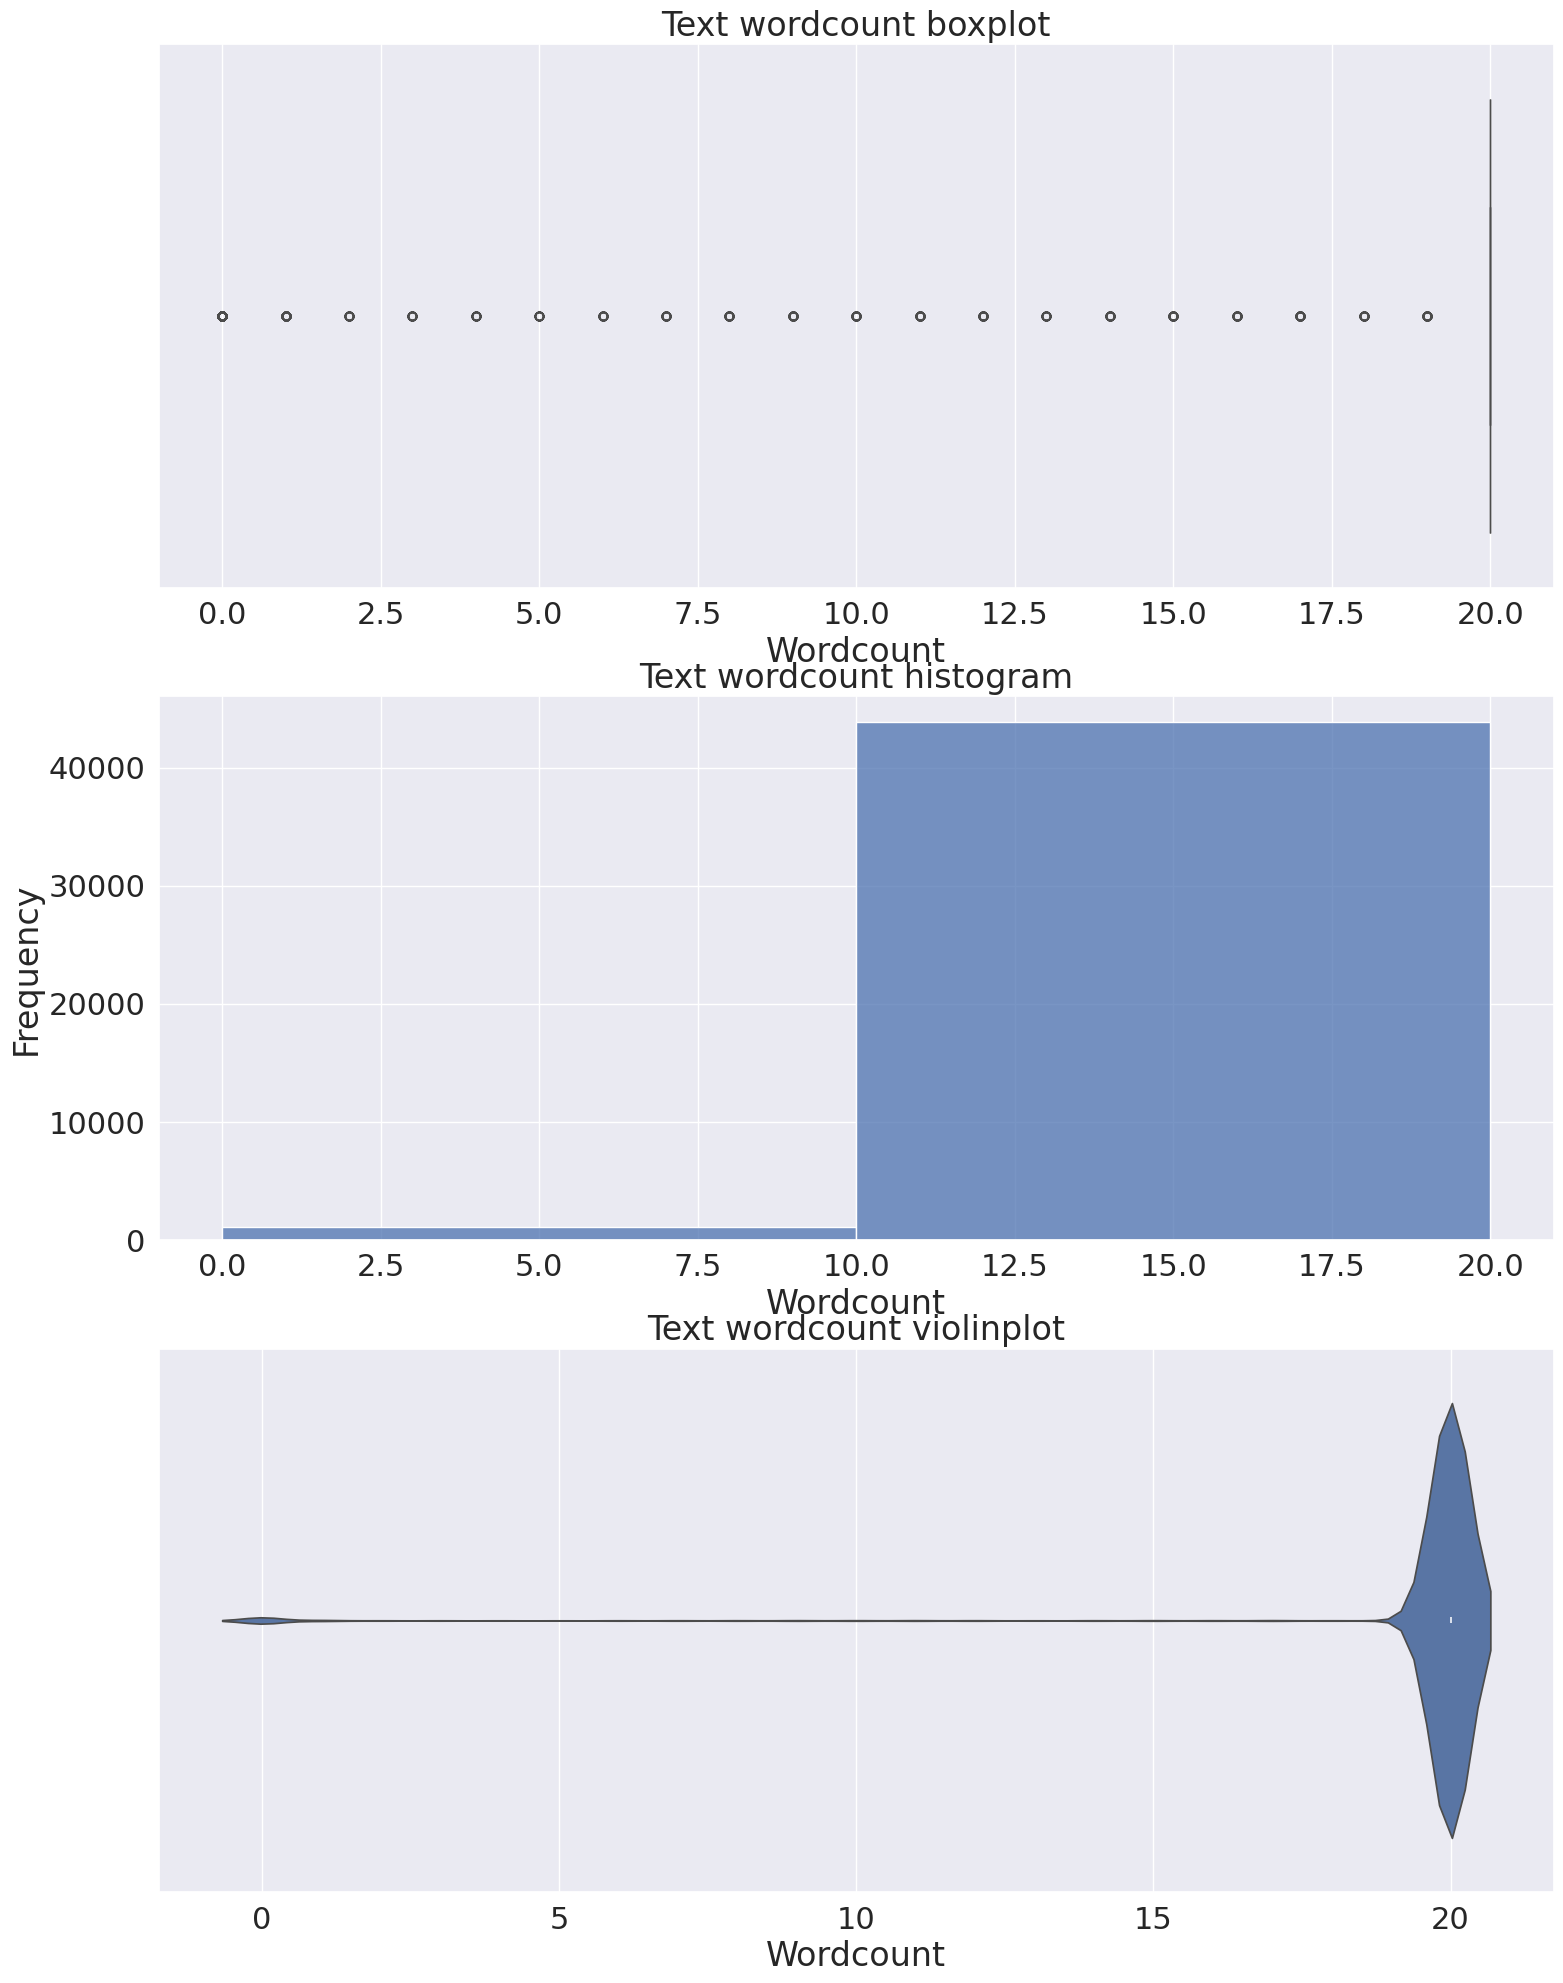

In [ ]:
# Word count analysis (Title)
f, axes = plt.subplots(3, 1, figsize=(18, 24))

# Plot distribution graphs (Boxplot & histogram & violinplot)
sb.boxplot(data=news["text_wordcount"], orient = "h", ax=axes[0]).set(
    title="Text wordcount boxplot",
    xlabel='Wordcount')
sb.histplot(data=news["text_wordcount"], binwidth=10, ax=axes[1]).set(
    title="Text wordcount histogram",
    xlabel='Wordcount',
    ylabel='Frequency')
sb.violinplot(data=news["text_wordcount"], orient = "h", ax = axes[2]).set(
    title="Text wordcount violinplot",
    xlabel='Wordcount')

In [ ]:
# view stats
news['text_wordcount'].describe()

count    44898.000000
mean        19.509399
std          2.852526
min          0.000000
25%         20.000000
50%         20.000000
75%         20.000000
max         20.000000
Name: text_wordcount, dtype: float64

### Text charcount

[Text(0.5, 1.0, 'Text charcount violinplot'), Text(0.5, 0, 'Wordcount')]

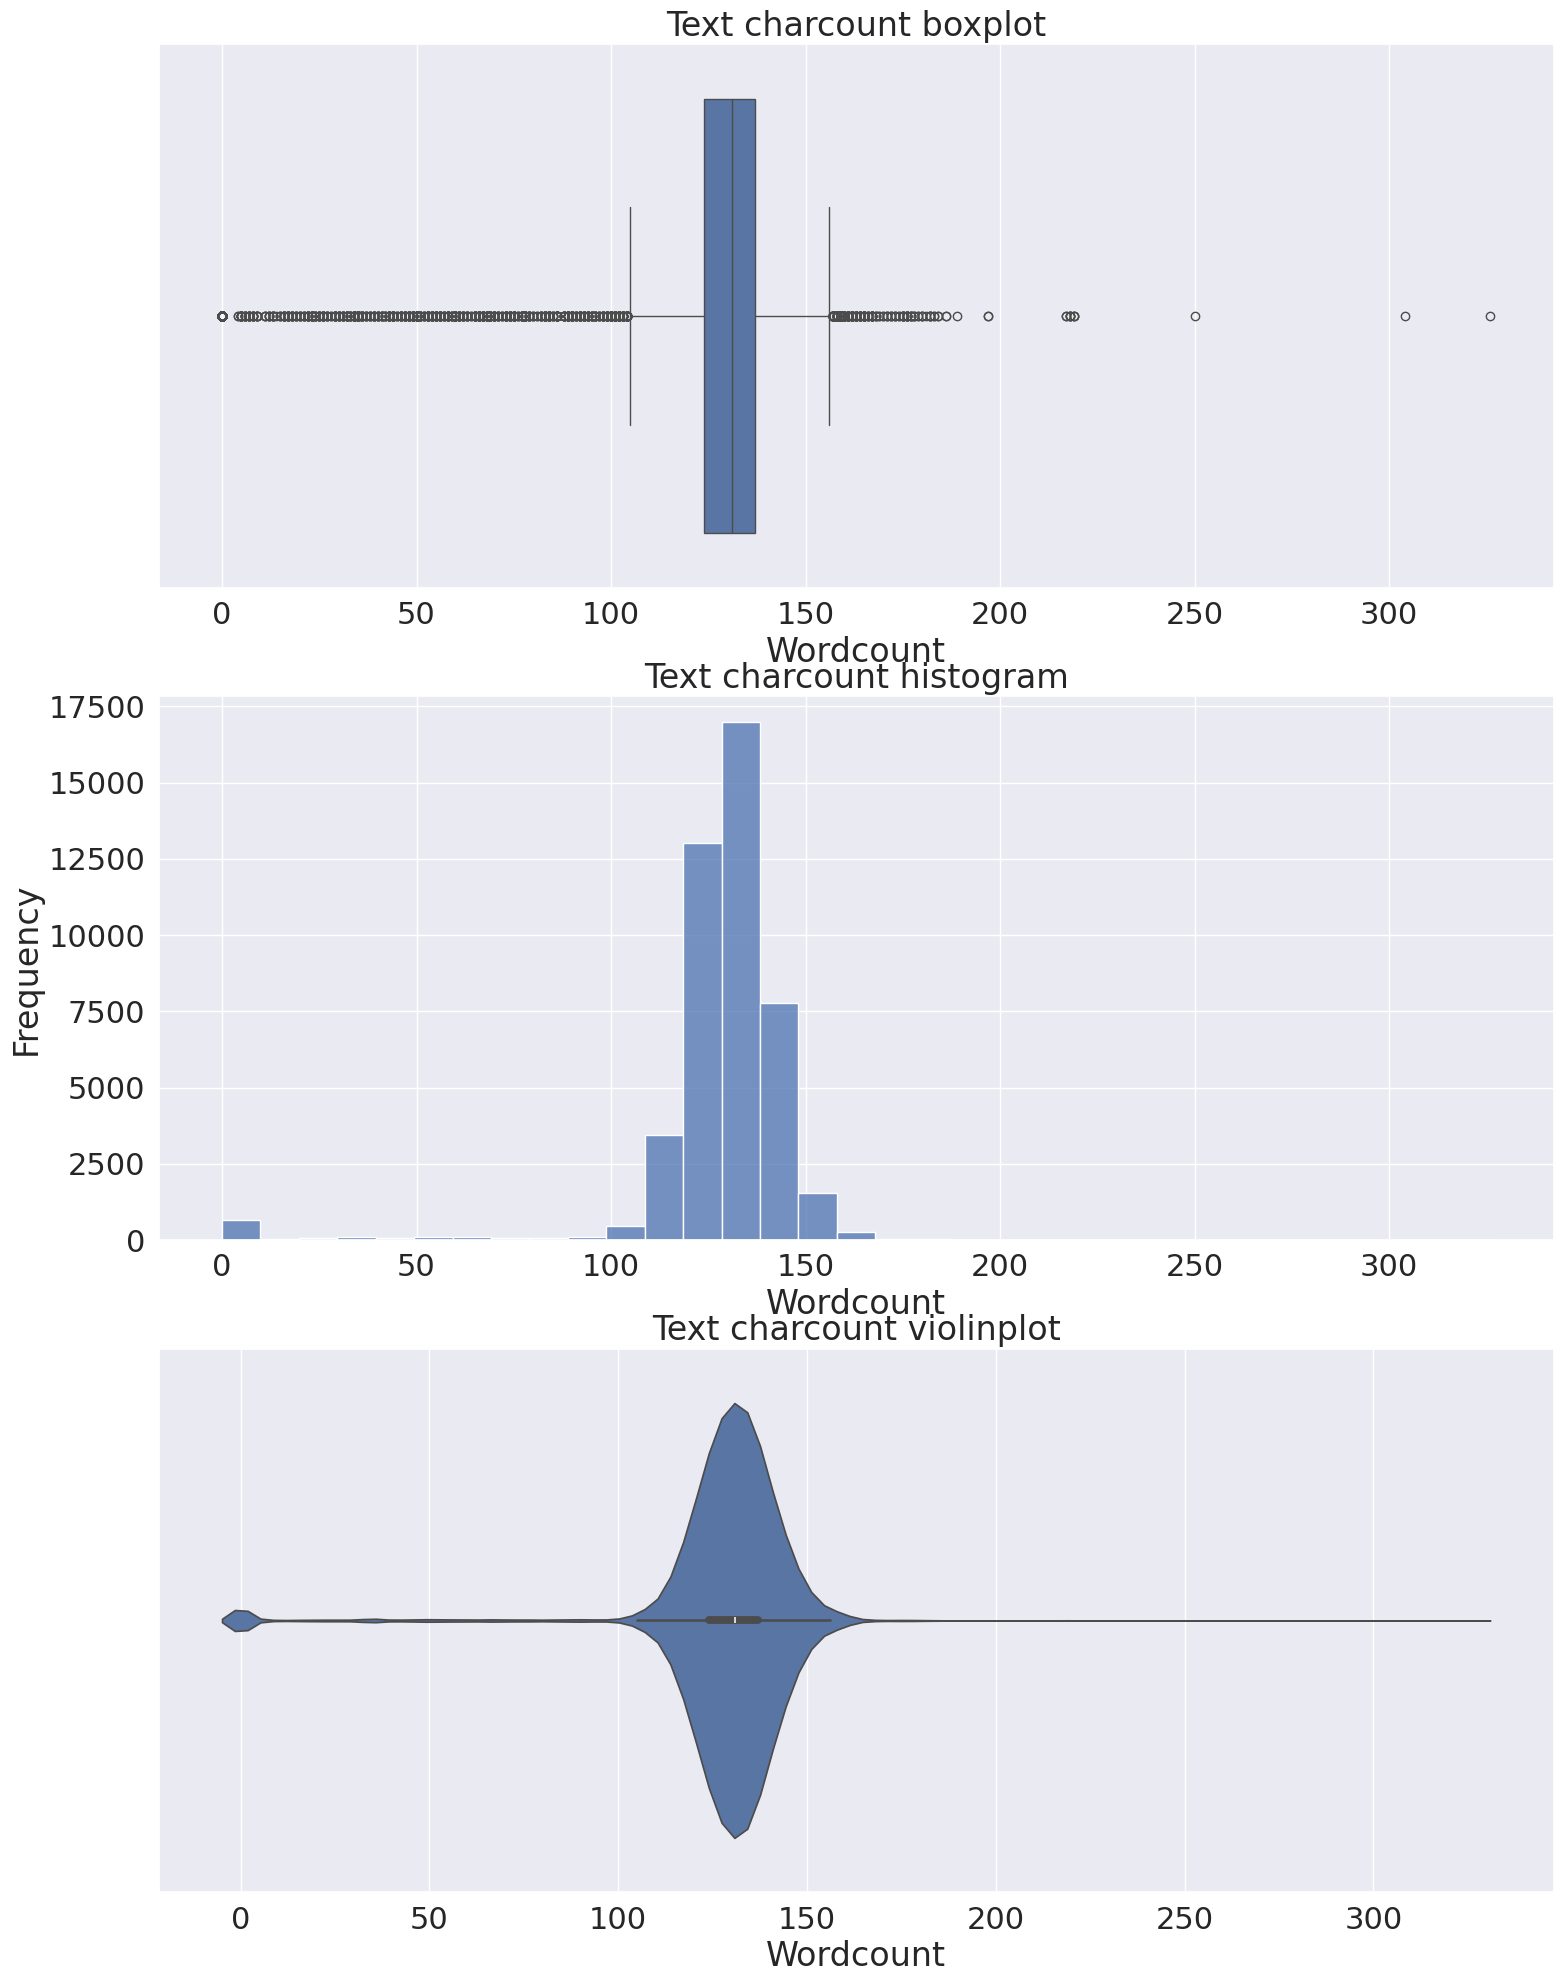

In [ ]:
# Word count analysis (Title)
f, axes = plt.subplots(3, 1, figsize=(18, 24))

# Plot distribution graphs (Boxplot & histogram & violinplot)
sb.boxplot(data=news["text_charcount"], orient = "h", ax=axes[0]).set(
    title="Text charcount boxplot",
    xlabel='Wordcount')
sb.histplot(data=news["text_charcount"], binwidth=10, ax=axes[1]).set(
    title="Text charcount histogram",
    xlabel='Wordcount',
    ylabel='Frequency')
sb.violinplot(data=news["text_charcount"], orient = "h", ax = axes[2]).set(
    title="Text charcount violinplot",
    xlabel='Wordcount')

In [ ]:
# view stats
news['text_charcount'].describe()

count    44898.000000
mean       128.301773
std         20.928321
min          0.000000
25%        124.000000
50%        131.000000
75%        137.000000
max        326.000000
Name: text_charcount, dtype: float64

## Word / Charcount distribution across classes

### Fake vs True title wordcount


[Text(0.5, 1.0, 'Title wordcount comparision'),
 Text(0.5, 0, 'Wordcount'),
 Text(0, 0.5, 'Label')]

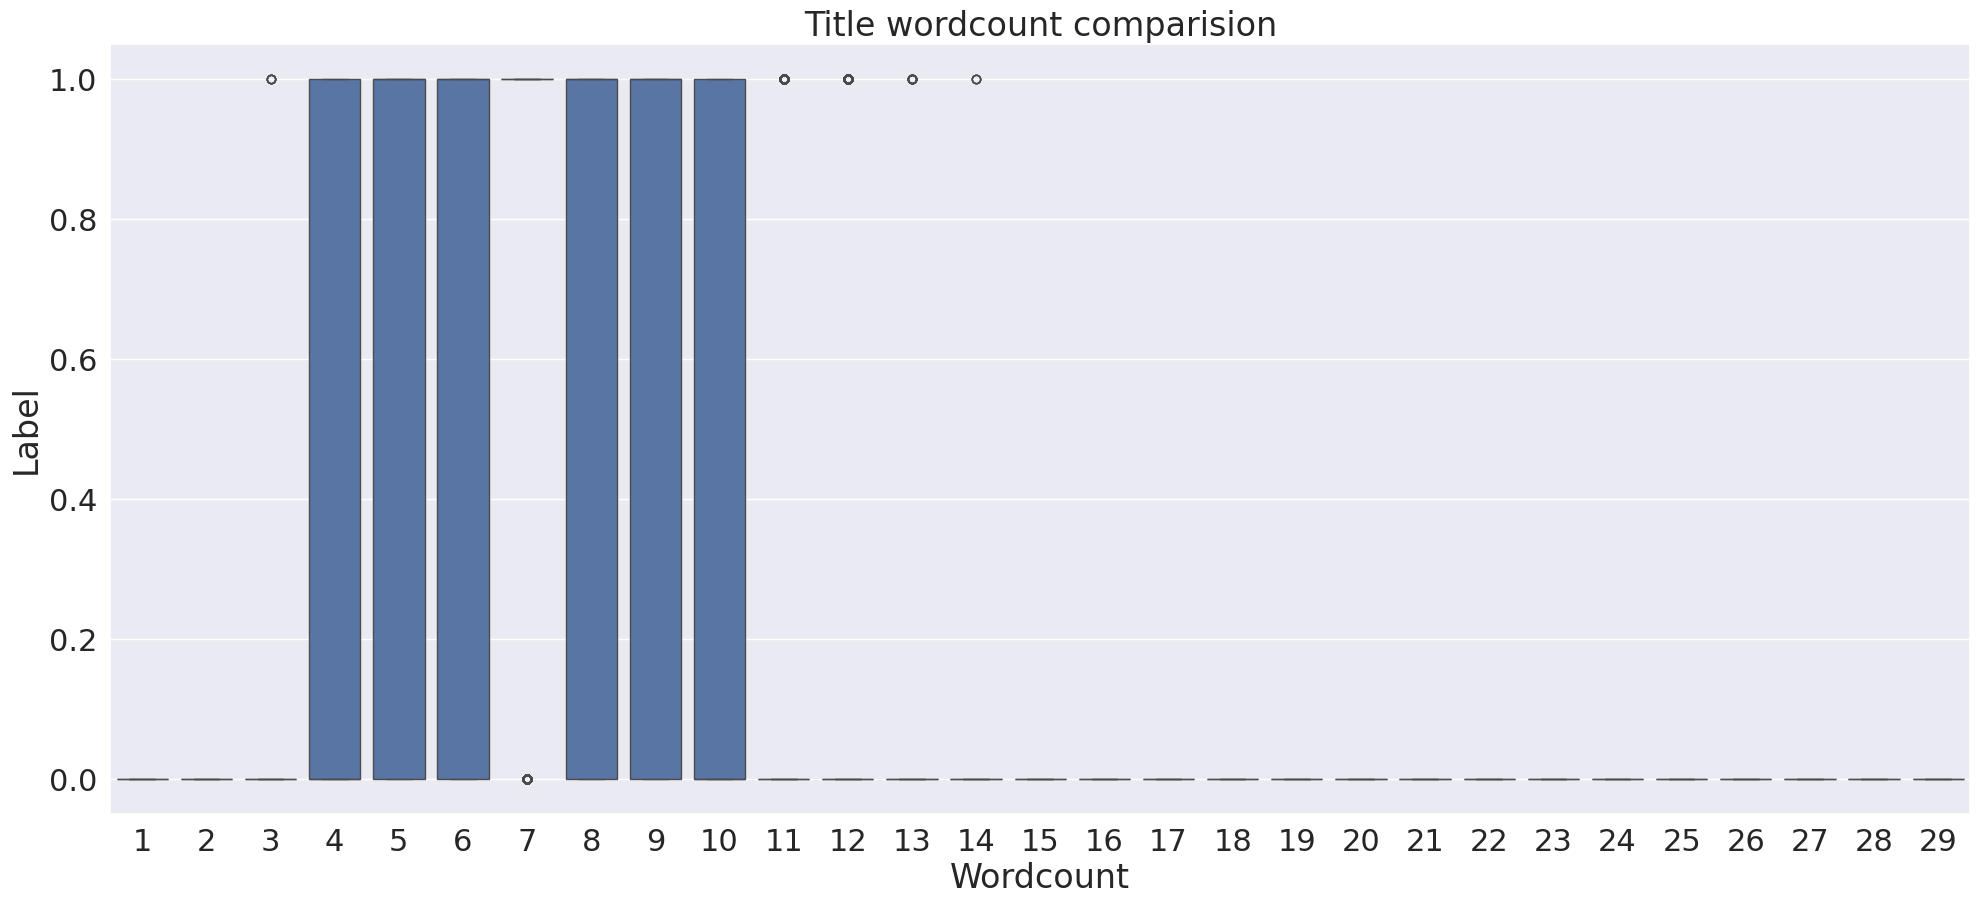

In [ ]:
# Plot histogram for both real and fake news word count
f = plt.figure(figsize=(24,10))

sb.boxplot(x=news["title_wordcount"], y=news["label_meaning"]).set(
    title="Title wordcount comparision",
    xlabel='Wordcount',
    ylabel='Label')

In [ ]:
# View stats
news.loc[news["label"] == 1]["title_wordcount"].describe()

count    21417.000000
mean         8.047999
std          1.338572
min          3.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         14.000000
Name: title_wordcount, dtype: float64

In [ ]:
# View stats
news.loc[news["label"] == 0]["title_wordcount"].describe()

count    23481.000000
mean        10.682296
std          3.096434
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         29.000000
Name: title_wordcount, dtype: float64

### Fake vs True text wordcount

[Text(0.5, 1.0, 'Text wordcount comparision'),
 Text(0.5, 0, 'Wordcount'),
 Text(0, 0.5, 'Label')]

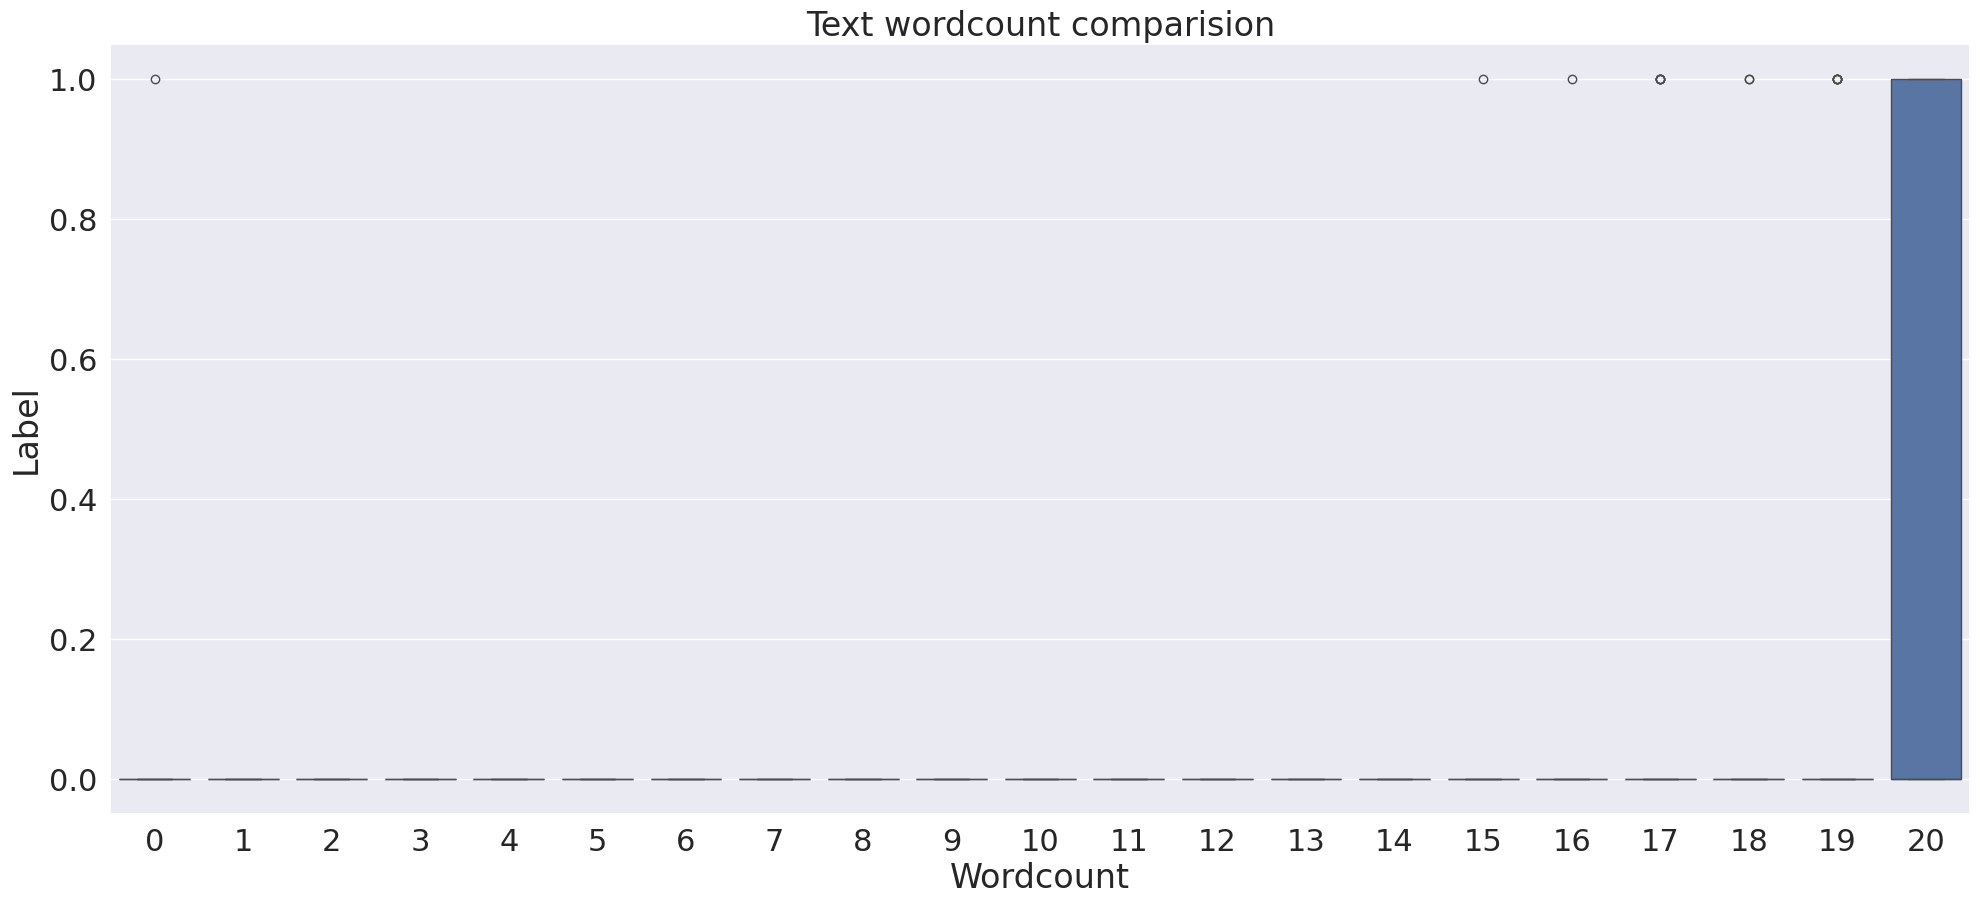

In [ ]:
# Plot histogram for both real and fake news word count
f = plt.figure(figsize=(24,10))
sb.boxplot(x=news["text_wordcount"], y=news["label_meaning"]).set(
    title="Text wordcount comparision",
    xlabel='Wordcount',
    ylabel='Label')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9f23536d-6e62-418a-b94b-ca9356b2599b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>